In [71]:
!pip install google-cloud-storage
!pip install MedPy
!pip install onedrivedownloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


In [81]:
import importlib
from joblib import dump, load
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Custom modules
import utils.mri_images as mri
import utils.mri_plotter as mrp
import utils.metrics as metrics

# Note: all modules need to be reloaded inside running jupyter notebooks to recognize live updates
# Todo: delete this when the functions are finalized
importlib.reload(mri)
importlib.reload(mrp)
importlib.reload(mri)

from utils.mri_images import MriImage, StructuralScan, MriType
from utils.mri_plotter import MRIPlotter

#### Test MRIImage Integration WITH GOOGLE STORAGE

In [ ]:
mri_img = MriImage()

struct_files = mri_img.list_mri_in_folder(mri_type=MriType.STRUCT_SCAN)

annot_files = mri_img.list_mri_in_folder(mri_type=MriType.ANNOTATED)
auto_segm_files = mri_img.list_mri_in_folder(mri_type=MriType.AUTO_SEGMENTED)
annot_reduced_files = mri_img.list_mri_in_folder(mri_type=MriType.ANNOTATED_REDUCED)
auto_segm_reduced_files = mri_img.list_mri_in_folder(mri_type=MriType.AUTO_SEGMENTED_REDUCED)

train_2d = mri_img.list_mri_in_folder(mri_type=MriType.TRAIN_2D)
val_2d = mri_img.list_mri_in_folder(mri_type=MriType.VAL_2D)
train_2d_cross = mri_img.list_mri_in_folder(mri_type=MriType.TRAIN_2D_CROSS)
val_2d_cross = mri_img.list_mri_in_folder(mri_type=MriType.VAL_2D_CROSS)

print("No. of struct files:", len(struct_files))

print("No. of segmented files:", len(annot_files))
print("No. of auto-segmented files:", len(auto_segm_files))
print("No. of segmented - reduced files:", len(annot_reduced_files))
print("No. of auto-segmented - reduced files:", len(auto_segm_reduced_files))

print("No. of train 2d files:", len(train_2d))
print("No. of val 2d files:", len(val_2d))
print("No. of train 2d cross files:", len(train_2d_cross))
print("No. of val_2d_cross files:", len(val_2d_cross))

directory content/data/images_structural/
directory content/data/images_segm/
directory content/data/automated_segm/
directory content/data/images_annot_reduced/
directory content/data/automated_segm_reduced/
directory content/data/train_2d/
directory content/data/val_2d/
directory content/data/train_2d_cross/
directory content/data/val_2d_cross/
No. of struct files: 2684
No. of segmented files: 147
No. of auto-segmented files: 611
No. of segmented - reduced files: 736
No. of auto-segmented - reduced files: 147
No. of train 2d files: 64240
No. of val 2d files: 21900
No. of train 2d cross files: 71720
No. of val_2d_cross files: 24450


#### Test MRIImage Integration WITH ONEDRIVE

In [ ]:
# Retrieve files from one drive

mri_img = MriImage(enable_gstorage=False)

struct_files = mri_img.list_mri_in_folder(mri_type=MriType.STRUCT_SCAN)

annot_files = mri_img.list_mri_in_folder(mri_type=MriType.ANNOTATED)
auto_segm_files = mri_img.list_mri_in_folder(mri_type=MriType.AUTO_SEGMENTED)
annot_reduced_files = mri_img.list_mri_in_folder(mri_type=MriType.ANNOTATED_REDUCED)
auto_segm_reduced_files = mri_img.list_mri_in_folder(mri_type=MriType.AUTO_SEGMENTED_REDUCED)

train_2d = mri_img.list_mri_in_folder(mri_type=MriType.TRAIN_2D)
val_2d = mri_img.list_mri_in_folder(mri_type=MriType.VAL_2D)
train_2d_cross = mri_img.list_mri_in_folder(mri_type=MriType.TRAIN_2D_CROSS)
val_2d_cross = mri_img.list_mri_in_folder(mri_type=MriType.VAL_2D_CROSS)

print("No. of struct files:", len(struct_files))

print("No. of segmented files:", len(annot_files))
print("No. of auto-segmented files:", len(auto_segm_files))
print("No. of segmented - reduced files:", len(annot_reduced_files))
print("No. of auto-segmented - reduced files:", len(auto_segm_reduced_files))

print("No. of train 2d files:", len(train_2d))
print("No. of val 2d files:", len(val_2d))
print("No. of train 2d cross files:", len(train_2d_cross))
print("No. of val_2d_cross files:", len(val_2d_cross))

directory /content/data/images_structural
directory /content/data/images_segm
directory /content/data/automated_segm
directory /content/data/images_annot_reduced
directory /content/data/automated_segm_reduced
directory /content/data/train_2d
directory /content/data/val_2d
directory /content/data/train_2d_cross
directory /content/data/val_2d_cross
No. of struct files: 671
No. of segmented files: 147
No. of auto-segmented files: 611
No. of segmented - reduced files: 735
No. of auto-segmented - reduced files: 147
No. of train 2d files: 64240
No. of val 2d files: 21900
No. of train 2d cross files: 71720
No. of val_2d_cross files: 24450


### HELPER FUNCTIONS FOR PLOTTING

In [82]:
mri_img = MriImage()
segment_ids = list(mri.SEGMENTS.keys())
segment_names = list(mri.SEGMENTS.values())

In [77]:
def get_nonzero_extents(arr):
  if not np.any(arr != 0):
    center = np.array(arr.shape) // 2
    minima = center - 1
    maxima = center + 1
    return minima, maxima
  else:
    indices = np.where(arr != 0)
    minima = np.min(indices, axis=1)
    maxima = np.max(indices, axis=1)
    return minima, maxima

def get_bounds(true_img_bin, pred_img_bin):
  min1, max1 = get_nonzero_extents(true_img_bin)
  min2, max2 = get_nonzero_extents(pred_img_bin)
  combined_min = np.minimum(min1, min2)
  combined_max = np.maximum(max1, max2)

  adj_min = np.maximum(combined_min-20, 0)
  adj_max = np.minimum(combined_max+20, np.array(true_img_bin.shape) - 1)
  return adj_min, adj_max

def convert_none_to_zero(img):
    converted_array = np.where(img==None, 0, img)
    return converted_array.astype(float)

def zoom_image(img, adj_min, adj_max):
  return img[adj_min[0]:adj_max[0]+1, adj_min[1]:adj_max[1]+1, :]

def plot_samples(subj_files_np, top_samples, hd95=False):
  nrows=len(top_samples)
  ncols=3

  mri_plt = MRIPlotter()
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 6*nrows))

  for idx, img_info in enumerate(top_samples):

    subj_file_idx, segment_idx, hd95 = img_info

    subj_file = subj_files_np[subj_file_idx]
    segment_id = segment_ids[segment_idx]
    segment_name = segment_names[segment_idx]

    # load flair image as base image
    base_img = mri_img.load_mri(subj_file=subj_file,
                                mri_type=MriType.STRUCT_SCAN,
                                struct_scan=StructuralScan.FLAIR)

    # load segmented and auto-segmented
    true_img = mri_img.load_mri(subj_file=subj_file,
                                mri_type=MriType.ANNOTATED)
    pred_img = mri_img.load_mri(subj_file=subj_file,
                                mri_type=MriType.AUTO_SEGMENTED)

    # get binary mask for segment with lowest dice score
    true_img_bin = (true_img == segment_id)
    pred_img_bin = (pred_img == segment_id)

    # get appropriate slice from true image
    z_idx = mri_img.get_largest_tumor_slice_idx(true_img_bin)[0]

    if hd95 == True:
    # get all surface distance
      hd95, surface_dist_pred, surface_dist_true =  metrics.plot_hausdorff_95(pred_img, true_img, segment=segment_id)
      surface_dist_true_2 = convert_none_to_zero(surface_dist_true)

      # get appropriate slice from true image
      z_idx = mri_img.get_largest_tumor_slice_idx(surface_dist_true_2, sum=True)[0]


    # Column 1: plot base image FLAIR and predicted mask as overlay
    mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=0,
                            title=f"{subj_file} - Slice: {z_idx}", auto_cbar=False, slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=true_img, fig=fig, axs=axs, row=idx, col=0, overlay=True, slice_idx=z_idx)

    # Column 2: plot full mri scan with specific segment
    mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=1,
                            title=f"{subj_file}- {segment_name} - {round(hd95, 2)}",
                            auto_cbar=False, slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=true_img_bin, fig=fig, axs=axs, row=idx, col=1,
                          segm_cbar=False, overlay=True, cmap='Oranges', slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=pred_img_bin, fig=fig, axs=axs, row=idx, col=1,
                          segm_cbar=False, overlay=True, cmap="Greens", slice_idx=z_idx)

    # add legend
    orange = mpatches.Patch(color='red', label='annotated')
    green = mpatches.Patch(color='green', label='predicted')
    axs[idx, 1].legend(handles=[orange, green], loc='upper left')


    # Column 3: plot zoomed view
    adj_min, adj_max = get_bounds(true_img_bin, pred_img_bin)
    base_zoomed = zoom_image(base_img.copy(), adj_min, adj_max)
    true_zoomed = zoom_image(true_img_bin.copy(), adj_min, adj_max)
    pred_zoomed = zoom_image(pred_img_bin.copy(), adj_min, adj_max)

    mri_plt.plot_struct_img(img_data=base_zoomed, fig=fig, axs=axs, row=idx, col=2,
                            title=f"{subj_file} - {segment_name} - {round(hd95, 2)}",
                            auto_cbar=False, slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=true_zoomed, fig=fig, axs=axs, row=idx, col=2,
                          segm_cbar=False, overlay=True, cmap='Oranges', slice_idx=z_idx)
    mri_plt.plot_segm_img(img_data=pred_zoomed, fig=fig, axs=axs, row=idx, col=2,
                          segm_cbar=False, overlay=True, cmap="Greens", slice_idx=z_idx)

    axs[idx, 2].legend(handles=[orange, green], loc='upper left')
  plt.show()

### CALCULATE METRICS

In [84]:
def calc_metric_all_segments(segments, metric_func, *args, **kwargs):
  results = []
  for segment in segments:
    result = metric_func(*args, **kwargs, segm_id=segment)
    results.append(result)
  return results

In [88]:
all_common_metrics = []
all_dice = []
all_hd95 = []
all_missclass_per_label = []
all_true_per_label = []
error_files = []

#### Uncomment to re-run calculation (this may take time)

In [89]:
# Calculate dice score one by one for each image to avoid out-of-memory issues
subj_files = [annot_file.split("_segm")[0] for annot_file in annot_files]
for subj_file in subj_files[0:2]:

  # load the segmented and auto segmented image of a file
  true_img = mri_img.load_mri(subj_file, mri_type=MriType.ANNOTATED)
  pred_img = mri_img.load_mri(subj_file, mri_type=MriType.AUTO_SEGMENTED)

  try:
      print(f"Calculating metrics for {subj_file}")

      # metric 1: just count incorrect labels vs true labels for each file
      misclassified_per_label = []
      true_per_label = []
      for segment_id in segment_ids:
        true_count = np.sum(true_img == segment_id)
        pred_count = np.sum(pred_img == segment_id)

        count_difference = abs(true_count - pred_count)

        true_per_label.append(true_count)
        misclassified_per_label.append(count_difference)

      # metric 2: other common metrics
      common_metrics = calc_metric_all_segments(segment_ids, metrics.calc_binary_metrics, pred_img, true_img)
      common_metrics_dict = {}
      for key in common_metrics[0]:
          common_metrics_dict[key] = [metric[key] for metric in common_metrics]

      # metric 3: dice coefficient
      dice_score = calc_metric_all_segments(segment_ids, metrics.calc_dice_score, pred_img, true_img)

      # metric 4: 95% Hausdorff
      hausdorff_val =  calc_metric_all_segments(segment_ids, metrics.calc_hausdorff_95, pred_img, true_img)

      # append only when there is no error:
      all_dice.append(dice_score)
      all_hd95.append(hausdorff_val)
      all_missclass_per_label.append(misclassified_per_label)
      all_true_per_label.append(true_per_label)
      all_common_metrics.append(common_metrics_dict)
  except Exception as ex:
      print(f"Error {subj_file}", ex)
      error_files.append(subj_file)

# remove error files from subj_files
print("errors", error_files)
subj_files = list(filter(lambda x: x not in error_files, subj_files))

print(f"New length after removing problematic images: {len(subj_files)}")
subj_files_np = np.array(subj_files)

variables_dict = {'subj_files_np': subj_files_np,
                  'error_files': error_files,
                  'all_dice': all_dice,
                  'all_hd95': all_hd95,
                  'all_missclass_per_label': all_missclass_per_label,
                  'all_true_per_label': all_true_per_label,
                  'all_common_metrics': all_common_metrics}

# Save to joblib. Running the entire calculation everytime takes time
# dump(variables_dict, os.path.join('temp_files', 'variables.joblib'))

Calculating metrics for UPENN-GBM-00002_11
Calculating metrics for UPENN-GBM-00006_11
errors []
New length after removing problematic images: 147


## RESULTS

In [92]:
# Read results from temp_file to save time
variables_dict = load(os.path.join('temp_files', 'variables.joblib'))

subj_files_np = variables_dict["subj_files_np"]
error_files = variables_dict["error_files"]
all_dice = variables_dict["all_dice"]
all_hd95 = variables_dict["all_hd95"]
all_missclass_per_label = variables_dict["all_missclass_per_label"]
all_true_per_label = variables_dict["all_true_per_label"]
all_common_metrics = variables_dict["all_common_metrics"]

### COUNT DIFFERENCE/ TRUE COUNT

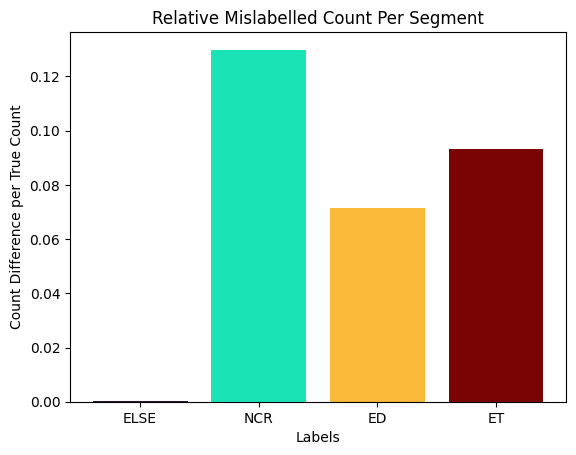

In [94]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))

total_misclassifed = np.array(all_missclass_per_label).sum(axis = 0)
true_count = np.array(all_true_per_label).sum(axis = 0)
plt.bar(range(len(segment_ids)), total_misclassifed/true_count, color=colors)
plt.xlabel('Labels')
plt.ylabel('Count Difference per True Count')
plt.title('Relative Mislabelled Count Per Segment')
plt.xticks(range(len(segment_ids)), segment_names)
plt.show()

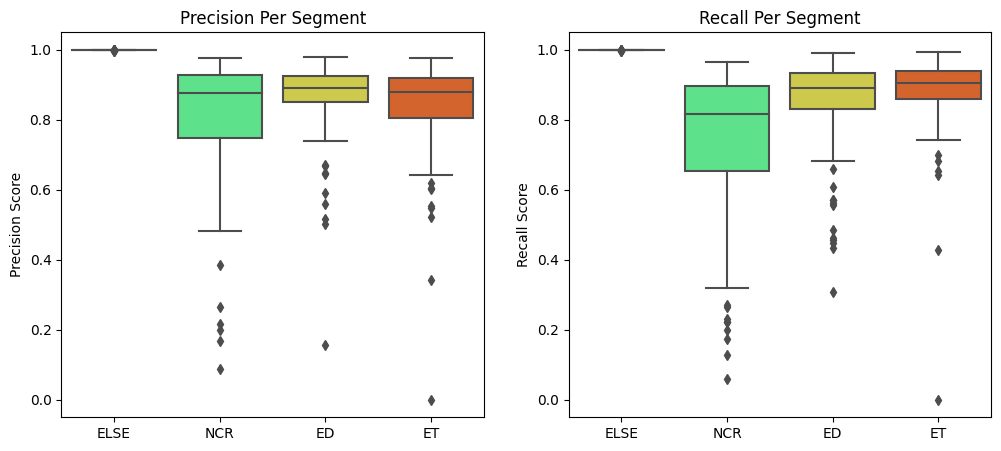

In [95]:
all_precision_np = np.array([metric['precision'] for metric in all_common_metrics])
all_recall_np = np.array([metric['recall'] for metric in all_common_metrics])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(data=all_precision_np,  palette="turbo", ax=axs[0])
sns.boxplot(data=all_recall_np,  palette="turbo", ax=axs[1])

axs[0].set_xticks(range(len(segment_ids)), segment_names)
axs[0].set_ylabel("Precision Score")
axs[0].set_title("Precision Per Segment")
axs[1].set_xticks(range(len(segment_ids)), segment_names)
axs[1].set_ylabel("Recall Score")
axs[1].set_title("Recall Per Segment")

plt.show()

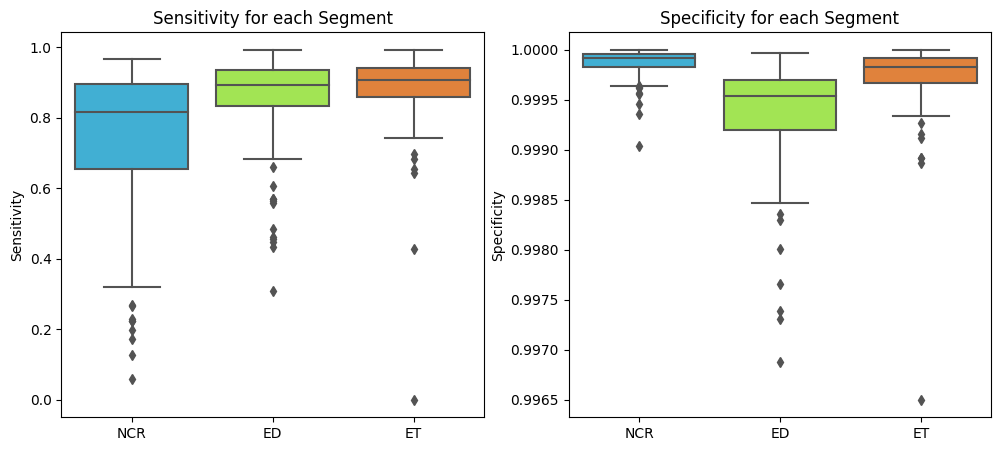

In [96]:
sensitivity_np = np.array([metric['sensitivity'] for metric in all_common_metrics])
specificity_np = np.array([metric['specificity'] for metric in all_common_metrics])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(data=sensitivity_np[:, 1:],  palette="turbo", ax=axs[0])
sns.boxplot(data=specificity_np[:, 1:],  palette="turbo", ax=axs[1])


axs[0].set_xticks(range(len(segment_ids)-1), segment_names[1:])
axs[0].set_ylabel("Sensitivity")
axs[0].set_title("Sensitivity for each Segment")

axs[1].set_xticks(range(len(segment_ids)-1), segment_names[1:])
axs[1].set_ylabel("Specificity")
axs[1].set_title("Specificity for each Segment")

plt.show()

### DICE SCORE

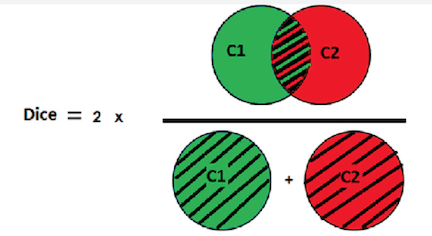

In [97]:
all_dice_np = np.array(all_dice)

In [98]:
dice_df = pd.DataFrame(all_dice_np, columns=segment_names)
dice_df.describe()[segment_names[1:]]

NCR          ED          ET
count  146.000000  146.000000  146.000000
mean     0.760164    0.856090    0.858294
std      0.188690    0.108087    0.104379
min      0.096948    0.246763    0.000000
25%      0.692616    0.841408    0.833762
50%      0.820174    0.881181    0.880397
75%      0.893082    0.919323    0.907925
max      0.970380    0.963036    0.969159

#### DICE SCORE PER SEGMENT

ED has the lowest (LABEL 1)

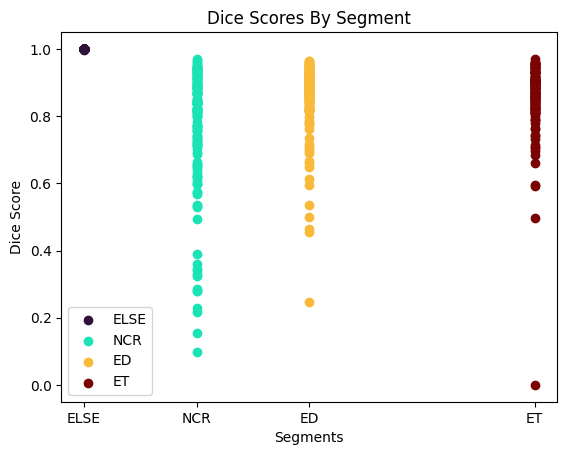

In [99]:
# Plot the dice scores as a scatter plot
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))

for idx in range(len(segment_ids)):
  dice_scores = np.array(all_dice)[:, idx]
  label = segment_ids[idx]
  x_val = [label] * len(dice_scores)

  plt.scatter(x_val, dice_scores, label=f"{segment_names[idx]}", color=colors[idx])
  plt.xlabel('Segments')
  plt.ylabel('Dice Score')
  plt.title('Dice Scores By Segment')
  plt.legend()

plt.xticks(segment_ids, segment_names)
plt.show()

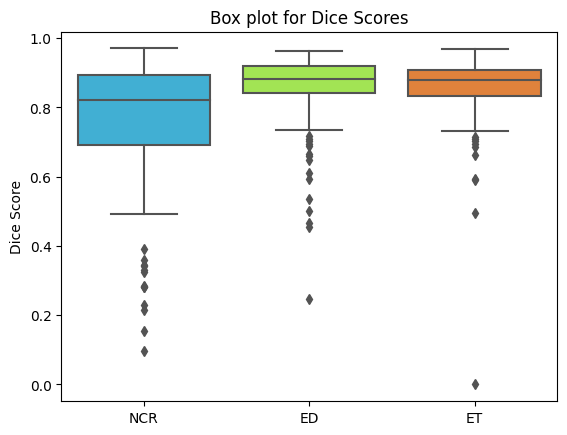

In [100]:
### Statistics
sns.boxplot(data=all_dice_np[:, 1:],  palette="turbo")
plt.xticks(range(len(segment_ids)-1), segment_names[1:])
plt.ylabel("Dice Score")
plt.title("Box plot for Dice Scores")
plt.show()

#### DICE SCORE FOR EACH FILE

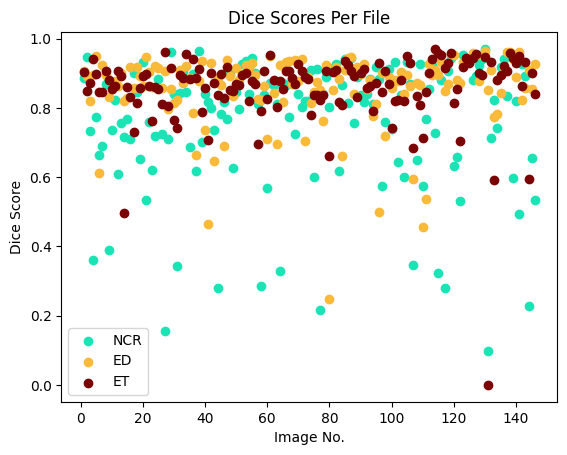

In [101]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))

scores_len = len(all_dice)

for segm_idx in range(1, len(segment_ids)):
  dice_scores = all_dice_np[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=colors[segm_idx], label=f"{segment_names[segm_idx]}")

plt.xlabel('Image No.')
plt.ylabel('Dice Score')
plt.title('Dice Scores Per File')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.legend()
plt.show()

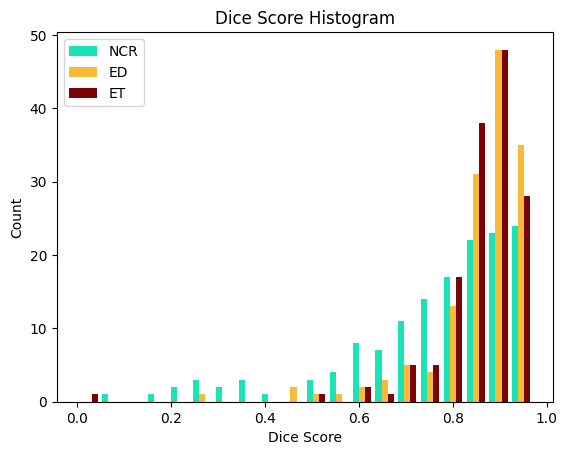

In [102]:
# Make a separate list for each segment
x2 = all_dice_np[:, 1]
x3 = all_dice_np[:, 2]
x4 = all_dice_np[:, 3]

# Assign colors for each segment and the names
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))
names = segment_names

plt.hist([x2, x3, x4], bins = 20, color = colors[1:], label=names[1:])
plt.legend()
plt.xlabel('Dice Score')
plt.ylabel('Count')
plt.title('Dice Score Histogram')
plt.show()

#### PLOT IMAGES WITH THE LOWEST DICE SCORES

In [103]:
# Flatten the array
flattened_array = all_dice_np.flatten()

# rearranges the elements such that the smallest 10 elements come before the 10th index
top_10_idx_1d = np.argpartition(flattened_array, kth=10)[:10]

# Reshape the indices back to the original 2D shape to get row (file number) and col (segment)
top_10_indices = np.unravel_index(top_10_idx_1d, all_dice_np.shape)
top_10_values = all_dice_np[top_10_indices]
top_10_worst_dice = list(zip(top_10_indices[0], top_10_indices[1], top_10_values))
top_10_worst_dice_sorted = sorted(top_10_worst_dice, key=lambda x: x[2])

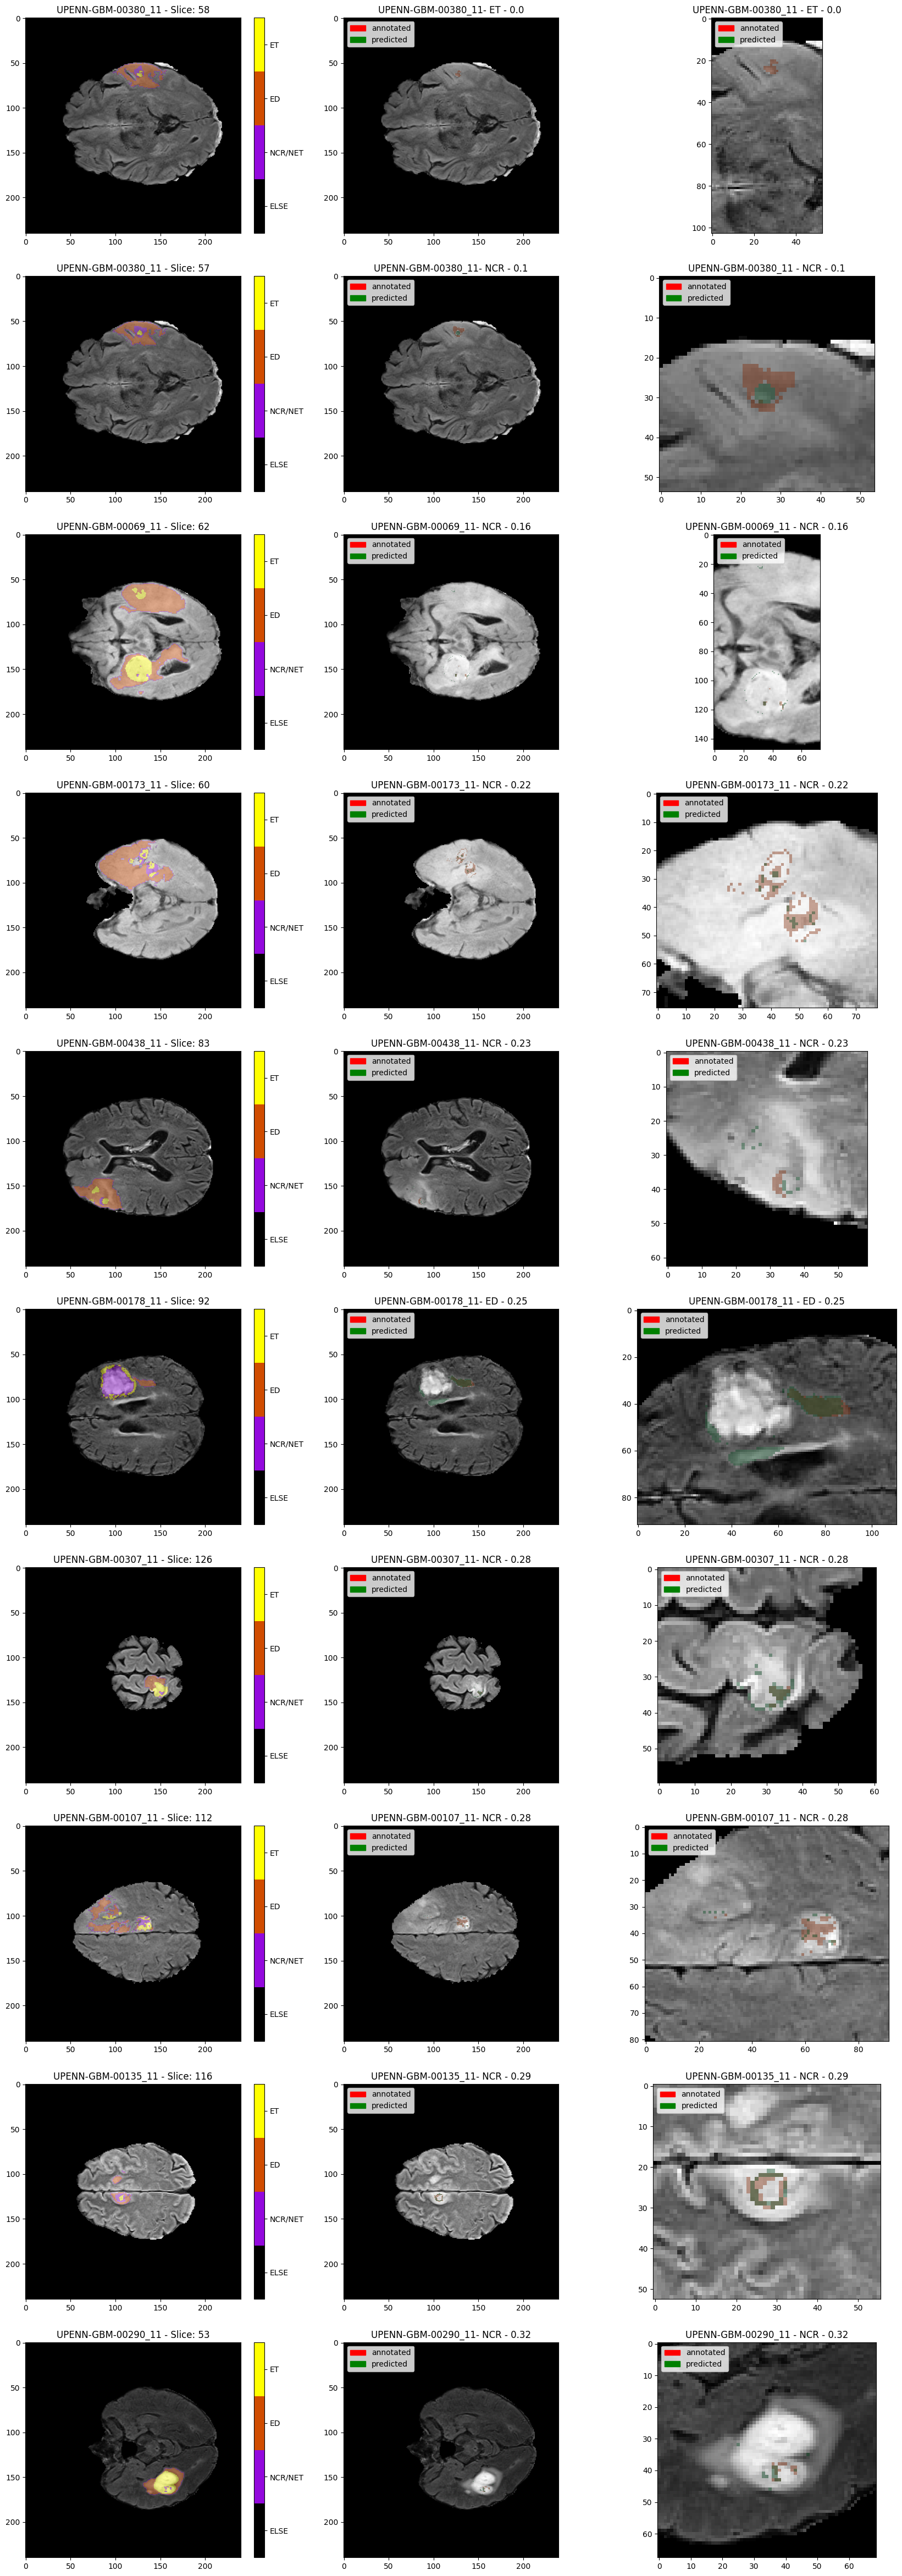

In [104]:
plot_samples(subj_files_np, top_10_worst_dice_sorted)

### HAUSDORFF DISTANCE

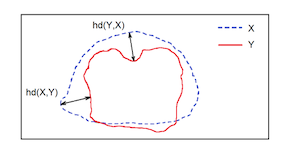

In [105]:
all_hd95_np = np.array(all_hd95)

In [107]:
hd95_df = df = pd.DataFrame(all_hd95_np, columns=segment_names)
hd95_df.describe()[segment_names[1:]]

NCR          ED          ET
count  146.000000  146.000000  146.000000
mean     2.732404    2.573481    2.483990
std      2.532398    2.622147   12.888790
min      1.000000    1.000000    1.000000
25%      1.414214    1.414214    1.000000
50%      2.236068    1.732051    1.000000
75%      3.162278    2.733693    1.000000
max     19.712929   17.029386  155.700994

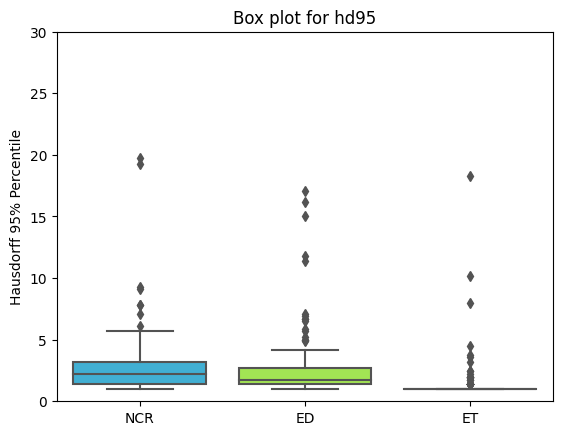

In [108]:
### Statistics
sns.boxplot(data=all_hd95_np[:,1:], palette="turbo")
plt.xticks(range(len(segment_ids)-1), segment_names[1:])
plt.ylabel("Hausdorff 95% Percentile")
plt.title("Box plot for hd95")
plt.ylim(0, 30)
plt.show()

#### HAUSDORFF DISTANCES PER SEGMENT

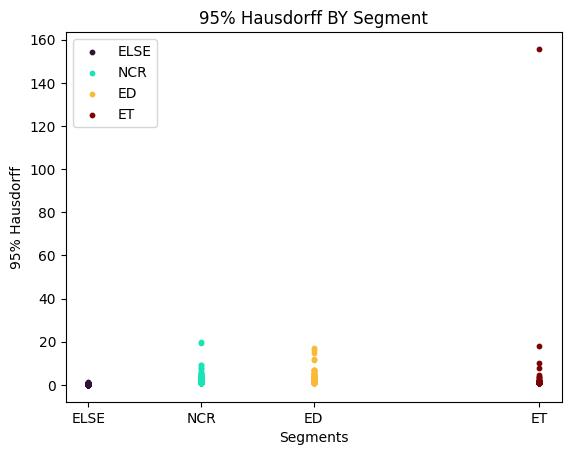

In [109]:
# Plot hausdorff scores as a scatter plot
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))

for idx in range(len(segment_ids)):
  y_val = all_hd95_np[:, idx]
  label = segment_ids[idx]
  x_val = [label] * len(y_val)

  plt.scatter(x_val, y_val, label=f"{segment_names[idx]}", color=colors[idx], s=10)
  plt.xlabel('Segments')
  plt.ylabel('95% Hausdorff')
  plt.title('95% Hausdorff BY Segment')
  plt.legend()

plt.xticks(segment_ids, segment_names)
plt.show()

#### HAUSDORFF DISTANCES PER FILE

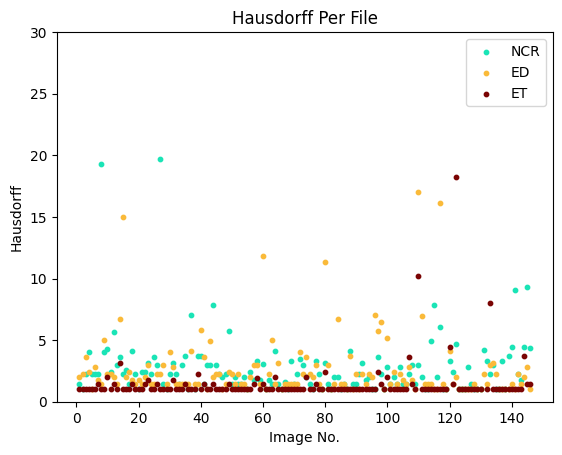

In [110]:
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))

scores_len = len(all_hd95)

for segm_idx in range(1, len(segment_ids)):
  dice_scores = all_hd95_np[:, segm_idx]
  plt.scatter(np.arange(1, scores_len+1), dice_scores, color=colors[segm_idx],
              label=f"{segment_names[segm_idx]}", s=10)

plt.xlabel('Image No.')
plt.ylabel('Hausdorff')
plt.title('Hausdorff Per File')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# hide outlier
plt.ylim(0, 30)

plt.legend()
plt.show()

#### PLOT IMAGES WITH HIGHEST HD95 SCORE

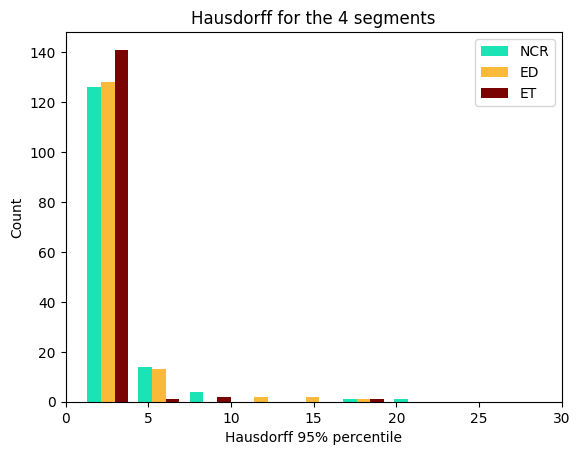

In [111]:
# Make a separate list for each segment
x2 = all_hd95_np[:, 1]
x3 = all_hd95_np[:, 2]
x4 = all_hd95_np[:, 3]

# Assign colors for each airline and the names
cmap = plt.get_cmap('turbo')
colors = cmap(np.linspace(0, 1, len(segment_ids)))
names = segment_names

plt.hist([x2, x3, x4], bins = 50, color = colors[1:], label=names[1:])
plt.legend()
plt.xlim(0, 30)
plt.xlabel('Hausdorff 95% percentile')
plt.ylabel('Count')
plt.title('Hausdorff for the 4 segments')
plt.show()

In [112]:
# Get 10 images with lowest hausdorff distance
# Flatten the array
flattened_array = all_hd95_np.flatten()

# Find the indices of the top 10 largest numbers
top_10_idx_1d = np.argpartition(flattened_array, kth=-10)[-10:]

# Reshape the indices back to the original 2D shape
top_10_indices = np.unravel_index(top_10_idx_1d, all_hd95_np.shape)
top_10_values = all_hd95_np[top_10_indices]
top_10_worst_hd = list(zip(top_10_indices[0], top_10_indices[1], top_10_values))
top_10_worst_hd_sorted = sorted(top_10_worst_hd, key=lambda x: -x[2])

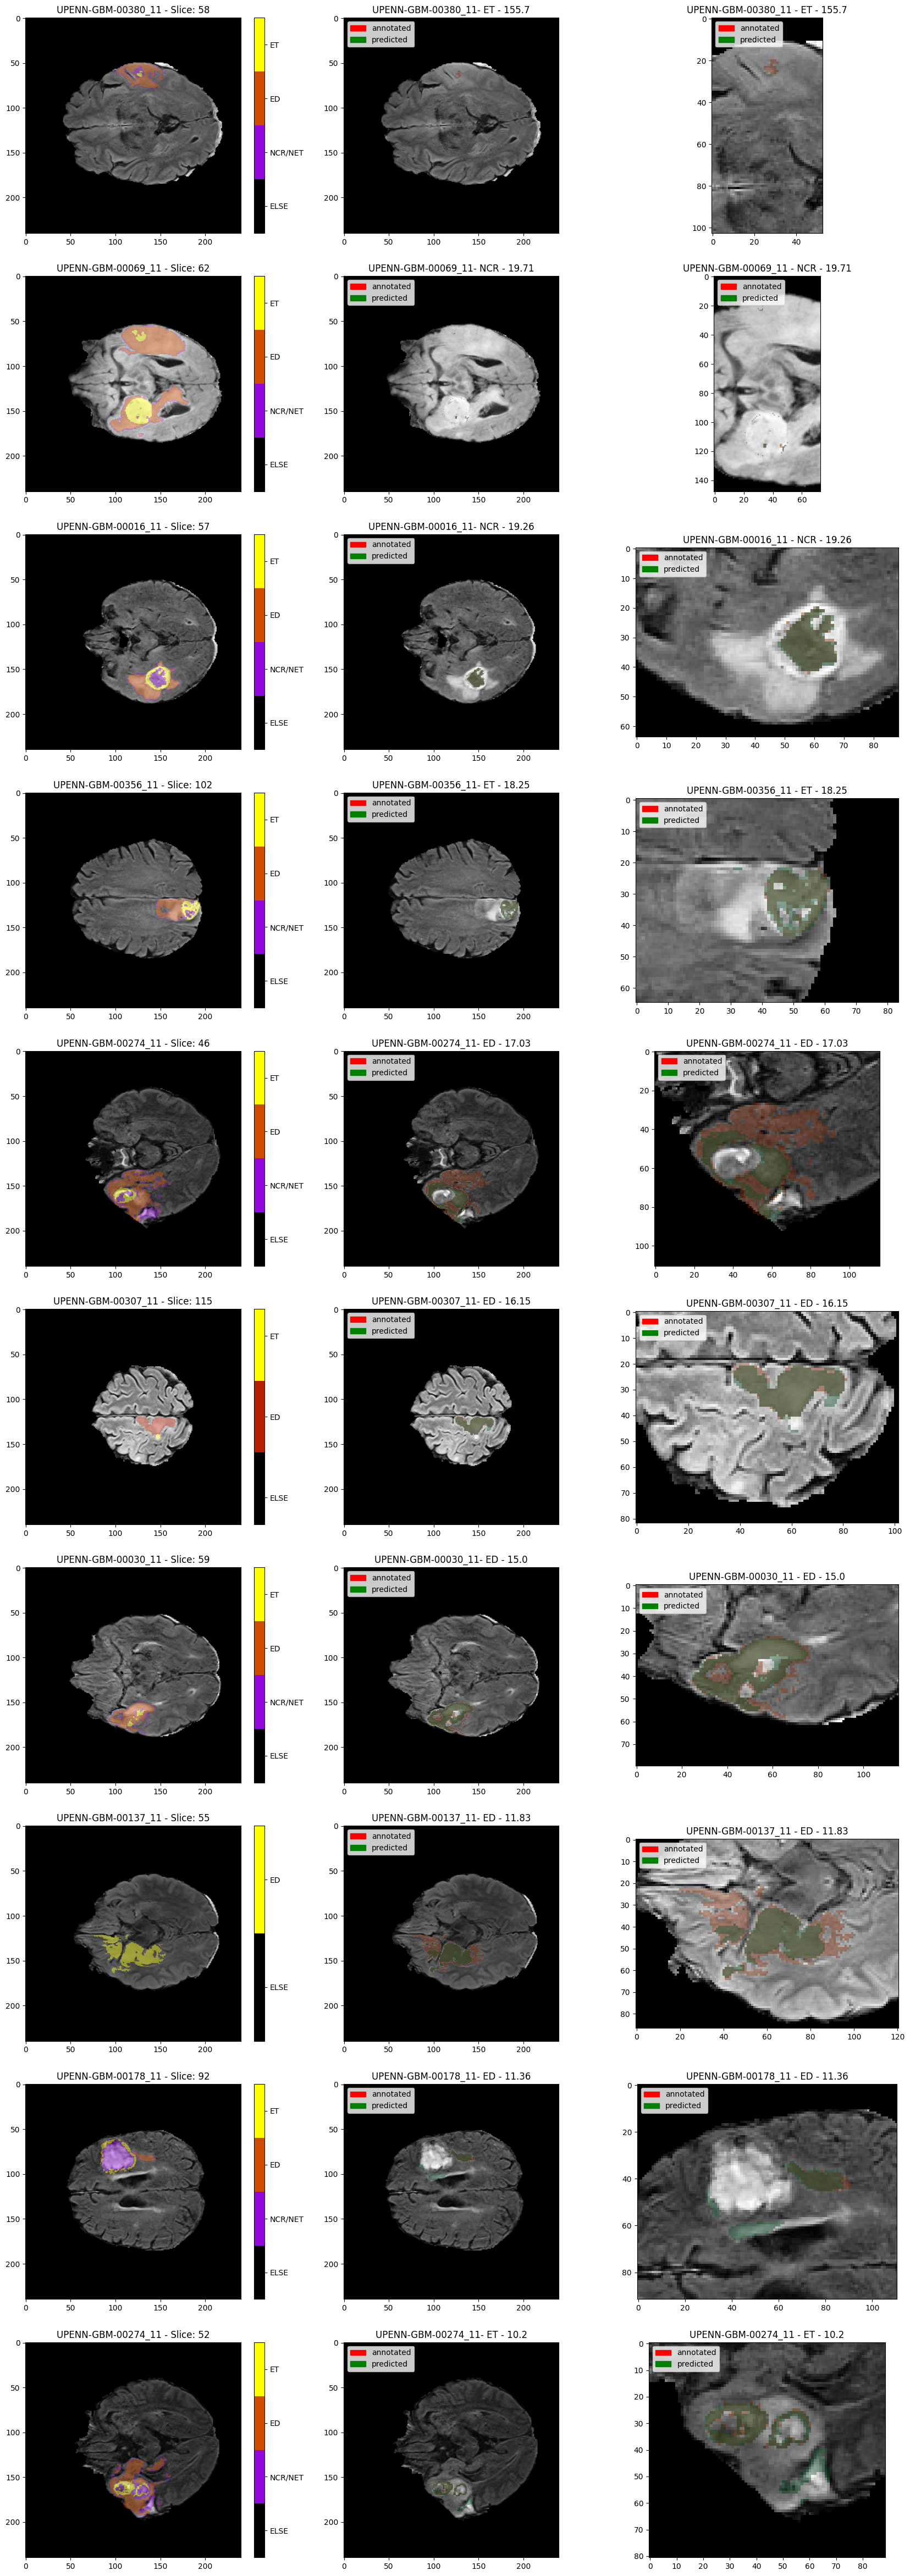

In [113]:
plot_samples(subj_files_np, top_10_worst_hd_sorted)

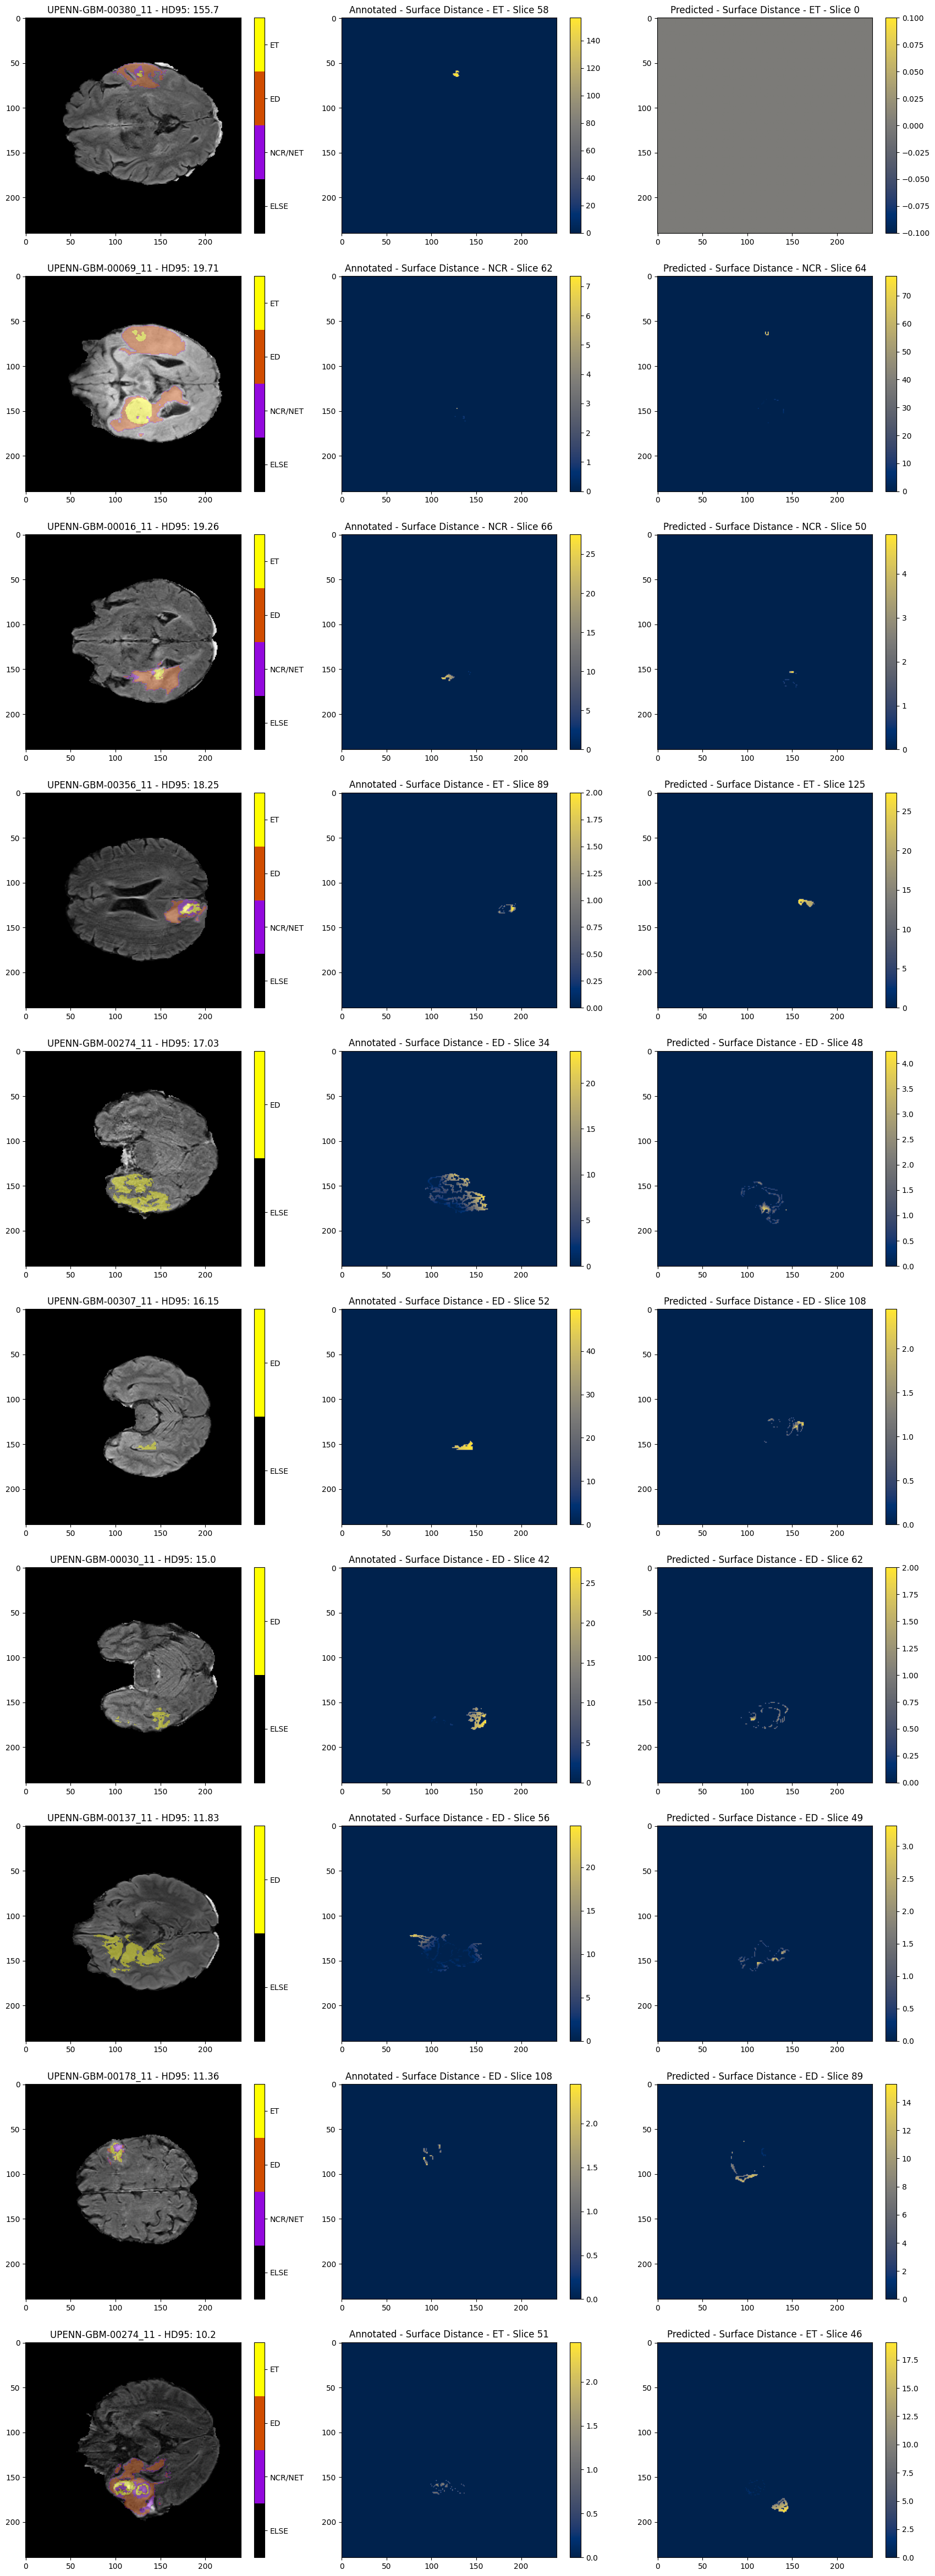

In [116]:
nrows=len(top_10_worst_hd_sorted)
ncols=3

mri_plt = MRIPlotter()
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 6*nrows))

for idx, img_info in enumerate(top_10_worst_hd_sorted):

  subj_file_idx, segment_idx, hd95 = img_info
  subj_file = subj_files_np[subj_file_idx]
  segment = segment_ids[segment_idx]
  segment_name = segment_names[segment_idx]

  # load flair image as base image
  base_img = mri_img.load_mri(subj_file=subj_file,
                                mri_type=MriType.STRUCT_SCAN,
                                struct_scan=StructuralScan.FLAIR)

  # load segmented and auto-segmented
  true_img = mri_img.load_mri(subj_file=subj_file, mri_type=MriType.ANNOTATED)
  pred_img = mri_img.load_mri(subj_file=subj_file, mri_type=MriType.AUTO_SEGMENTED)

  # get binary mask for segment with lowest dice score
  true_img_bin = (true_img == segment)
  pred_img_bin = (pred_img == segment)

  # get all surface distance
  hd95, surface_dist_pred, surface_dist_true =  metrics.plot_hausdorff_95(pred_img, true_img, segm_id=segment)
  surface_dist_pred_2 = convert_none_to_zero(surface_dist_pred)
  surface_dist_true_2 = convert_none_to_zero(surface_dist_true)

  # get appropriate slice from true image
  z_idx = mri_img.get_largest_tumor_slice_idx(surface_dist_true_2, sum=True)[0]

  # column 1 plot base image FLAIR and predicted mask
  mri_plt.plot_struct_img(img_data=base_img, fig=fig, axs=axs, row=idx, col=0,
                          title=f"{subj_file} - HD95: {round(hd95, 2)}", auto_cbar=False, slice_idx=z_idx)
  mri_plt.plot_segm_img(img_data=true_img, fig=fig, axs=axs, row=idx, col=0, overlay=True, slice_idx=z_idx)


  # column 2
  mri_plt.plot_img(img_data=surface_dist_true_2, fig=fig, axs=axs, row=idx,
                   col=1, title=f"Annotated - Surface Distance - {segment_name} - Slice {z_idx}", slice_idx=z_idx, cmap="cividis")

  # column 3
  z_idx_pred = mri_img.get_largest_tumor_slice_idx(surface_dist_pred_2, sum=True)[0]
  mri_plt.plot_img(img_data=surface_dist_pred_2, fig=fig, axs=axs, row=idx,
                   col=2, title=f"Predicted - Surface Distance - {segment_name} - Slice {z_idx_pred}", slice_idx=z_idx_pred, cmap="cividis")

plt.show()